In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

import cartopy.crs as ccrs
import cartopy.feature as cfeat

In [14]:
# Reusable function to plot AIS data to a map
def plot_positions_to_map(ais) :
    fig = plt.figure(figsize = (13, 13))
    ax = fig.add_subplot(1, 1, 1, projection = ccrs.Mercator())
    
    ax.add_feature(cfeat.LAND.with_scale('50m'))
    ax.add_feature(cfeat.OCEAN.with_scale('50m'))
    ax.add_feature(cfeat.COASTLINE.with_scale('50m'))
    ax.add_feature(cfeat.BORDERS.with_scale('50m'))
    
    min_long = ais['Longitude'].min() - 0.5
    max_long = ais['Longitude'].max() + 0.5
    min_lat = ais['Latitude'].min() - 0.5
    max_lat = ais['Latitude'].max() + 0.5
    
    ax.set_extent([min_long, max_long, min_lat, max_lat])
    
    ax.scatter(x = ais['Longitude'], y = ais['Latitude'], transform = ccrs.Geodetic())
    
    return

In [3]:
# Load the data
names = ['TripID', 'MMSI', 'StartLatitude', 'StartLongitude', 'StartTime', 'EndLatitude', 'EndLongitude', 'EndTime',
         'StartPort', 'EndPort', 'ID', 'time', 'shiptype', 'Length', 'Breadth', 'Draught', 'Latitude', 'Longitude',
         'SOG', 'COG', 'TH', 'Destination', 'Name', 'Callsign', 'AisSourcen']
ais = pd.read_csv('rotterdam_hamburg.arff', names = names, skiprows = 27, parse_dates = True, index_col = 'ID',
                  na_values = ['?'], dtype = {'TripID': str, 'MMSI': str, 'shiptype': str})

In [4]:
# Delete AisSourcen column
ais = ais.drop(['AisSourcen'], axis = 1)

In [5]:
ais.head()

,TripID,MMSI,StartLatitude,StartLongitude,StartTime,EndLatitude,EndLongitude,EndTime,StartPort,EndPort,...,Breadth,Draught,Latitude,Longitude,SOG,COG,TH,Destination,Name,Callsign
ID,,,,,,,,,,,,,,,,,,,,,
39110154,21109,210481000,51.94,4.05,'2016-1-21 04:32',53.53,9.91,'2016-1-22 06:04',ROTTERDAM,HAMBURG,...,32,10.64,53.95,7.82,14.7,81.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2
39112959,21109,210481000,51.94,4.05,'2016-1-21 04:32',53.53,9.91,'2016-1-22 06:04',ROTTERDAM,HAMBURG,...,32,10.64,53.95,7.83,14.7,80.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2
39118599,21109,210481000,51.94,4.05,'2016-1-21 04:32',53.53,9.91,'2016-1-22 06:04',ROTTERDAM,HAMBURG,...,32,10.64,53.95,7.83,14.7,81.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2
39123728,21109,210481000,51.94,4.05,'2016-1-21 04:32',53.53,9.91,'2016-1-22 06:04',ROTTERDAM,HAMBURG,...,32,10.64,53.95,7.84,14.7,80.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2
39127583,21109,210481000,51.94,4.05,'2016-1-21 04:32',53.53,9.91,'2016-1-22 06:04',ROTTERDAM,HAMBURG,...,32,10.64,53.95,7.85,14.7,81.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2


In [6]:
# Convert time columns to correct dtype
ais['StartTime'] = pd.to_datetime(ais['StartTime'], format = '\'%Y-%m-%d %H:%M\'')
ais['EndTime'] = pd.to_datetime(ais['EndTime'], format = '\'%Y-%m-%d %H:%M\'')
ais['time'] = pd.to_datetime(ais['time'], format = '\'%Y-%m-%d %H:%M\'')

In [7]:
ais.head()

,TripID,MMSI,StartLatitude,StartLongitude,StartTime,EndLatitude,EndLongitude,EndTime,StartPort,EndPort,...,Breadth,Draught,Latitude,Longitude,SOG,COG,TH,Destination,Name,Callsign
ID,,,,,,,,,,,,,,,,,,,,,
39110154,21109,210481000,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 06:04:00,ROTTERDAM,HAMBURG,...,32,10.64,53.95,7.82,14.7,81.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2
39112959,21109,210481000,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 06:04:00,ROTTERDAM,HAMBURG,...,32,10.64,53.95,7.83,14.7,80.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2
39118599,21109,210481000,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 06:04:00,ROTTERDAM,HAMBURG,...,32,10.64,53.95,7.83,14.7,81.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2
39123728,21109,210481000,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 06:04:00,ROTTERDAM,HAMBURG,...,32,10.64,53.95,7.84,14.7,80.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2
39127583,21109,210481000,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 06:04:00,ROTTERDAM,HAMBURG,...,32,10.64,53.95,7.85,14.7,81.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2


In [8]:
# Convert all headings that are 511 (>= 360) to NaN
invalid_headings = ais['TH'] >= 360
ais['TH'][invalid_headings] = np.nan

/Users/jankaiser/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
ais['TH']

ID
39110154       80.0
39112959       80.0
39118599       80.0
39123728       80.0
39127583       80.0
39129530       80.0
39134094       80.0
39135883       80.0
39138914       80.0
39142346       80.0
39144122       79.0
39146589       78.0
39147541       78.0
39149944       78.0
39151995       78.0
39153860       79.0
39155436       79.0
39157081       79.0
39159400       79.0
39161821       79.0
39163509       79.0
39166437       79.0
39168929       79.0
39170158       79.0
39172682       79.0
39173461       79.0
39176090       79.0
39177923       79.0
39180188       79.0
39182150       79.0
              ...  
1553201771    353.0
1553209182    354.0
1553214136    353.0
1553221542    352.0
1553224000      NaN
1553226483    352.0
1553228918    352.0
1553233820    353.0
1553236269    354.0
1553238730    354.0
1553241185    354.0
1553251166    355.0
1553256100    356.0
1553261107    354.0
1553266033    354.0
1548277150     69.0
1553268510    353.0
1548292486     20.0
1553273472    353

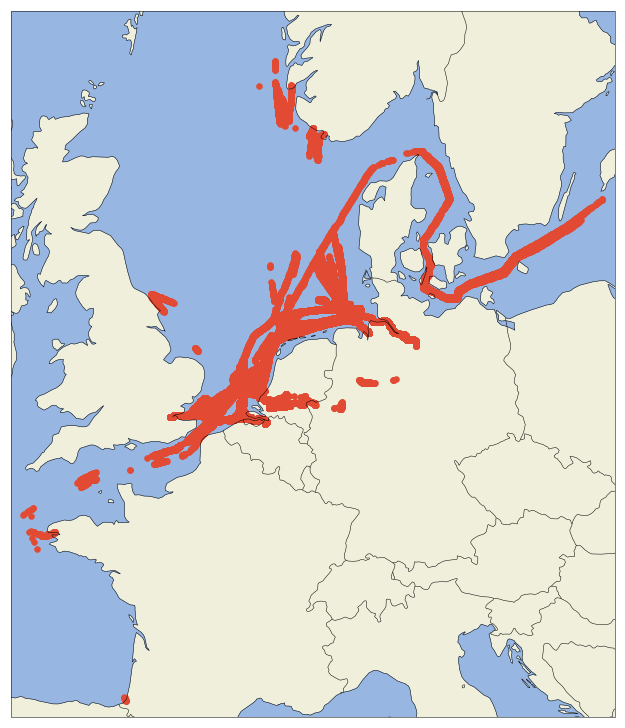

In [15]:
plot_positions_to_map(ais)